In [267]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import cv2 as cv
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from torchvision.transforms import ToTensor

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix

import pylab as pl
from IPython import display
from tqdm import tqdm

torch.manual_seed(33)

In [ ]:
import pandas as pd

images_path = 'images/'
annotations_path = 'annotations/list.txt'

with open(annotations_path, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

columns = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=columns)

df["Image"] = images_path + df["Image"] + '.jpg'
df["CLASS-ID"] = df["CLASS-ID"].astype('int64')
df["SPECIES"] = df["SPECIES"].astype('int64')
df["BREED ID"] = df["BREED ID"].astype('int64')

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].apply(lambda x: x - 1)

print(df)

In [ ]:
species_counts = df['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [ ]:
cats_df = df[df['SPECIES'] == 0]
dogs_df = df[df['SPECIES'] == 1]

min_samples = min(len(cats_df), len(dogs_df))
cats_sampled = cats_df.sample(n=min_samples, random_state=42)
dogs_sampled = dogs_df.sample(n=min_samples, random_state=42)

df_balanced = pd.concat([cats_sampled, dogs_sampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


species_counts = df_balanced['SPECIES'].map({0: 'Cat', 1: 'Dog'}).value_counts()

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.title('Percentage of Species')
plt.pie(species_counts, labels=species_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

### OUR CNN

In [ ]:
X = df_balanced[["Image"]]
y = df_balanced[["SPECIES"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['SPECIES'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['SPECIES'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

In [ ]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.title(f"Predicted class: {labels[0].item()}")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [ ]:
from collections import OrderedDict

class SuperCNNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SuperCNNSuperGuay, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, 5, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(5, 10, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(24*6*6, 200)
        self.linear_2 = nn.Linear(200, 10)
        self.linear_3 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv_1(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_2(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_3(x)
        x = self.max_pool2d(x)
        x = self.relu(x)
        
        x = self.conv_4(x)
        x = self.max_pool2d(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear_2(x)
        x = self.relu(x)

        x = self.linear_3(x)

        return F.log_softmax(x, dim=1)
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [

                ]
            )
        )
    
class SuperFCNSuperGuay(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, init_features=32):
        super(SuperFCNSuperGuay, self).__init__()
        
      
        # Encoder layers (downsampling)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Decoder layers (upsampling)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder (downsampling)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Decoder (upsampling)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)

        # Apply sigmoid activation for binary classification
        x = self.sigmoid(x)

        return x

In [ ]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = SuperFCNSuperGuay().to(device)

epochs = 5
lr = 1e-3

optimizer = Adam(model.parameters(), lr=lr)

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:
    
    train_loss = 0 
    val_loss = 0  
    
    model.train()                                                  
    for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        input_img= input_img.to(device)
        optimizer.zero_grad()     
        
        target = target.to(device)
        output = model(input_img)
        print(output.shape)
    
        loss = F.binary_cross_entropy(output.view(-1), target.float())
        loss.backward()                                            
        
        optimizer.step()                                               
        
        train_loss += loss.item()    
                                                       
    model.eval()   
    with torch.no_grad():                                          
        for input_img, target in test_dl: 
            input_img = input_img.to(device)
            target = target.to(device)
            
            output = model(input_img)                                   
            loss = F.cross_entropy(output, target, reduction='sum') 
            val_loss += loss.item()  
    
    # RESULTATS
    train_loss /= len(train_dl)
    t_loss[epoch-1] = train_loss
    
    val_loss /= len(test_dl)   
    v_loss[epoch-1] = val_loss
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

In [ ]:
from sklearn.metrics import confusion_matrix

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

            # Collect true and predicted labels for the confusion matrix
            all_true_labels.extend(y.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

        accuracy = num_correct / num_samples
        print(f"Accuracy: {accuracy * 100:.2f}%")

    model.train()
    
    class_names = list(set(all_true_labels + all_predicted_labels))

    sns.heatmap(confusion_matrix(all_true_labels, all_predicted_labels), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

In [ ]:
import torch
import torch.nn as nn
import torchvision

class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2, bias=True)
        )
    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModel()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-3
num_epochs = 4

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

In [ ]:
data, label = next(iterador)
photo = data[0][0]
plt.imshow(photo)
plt.axis("off")
plt.title(f"Class: {label[0].item()}")
plt.show()

# # Convert data to float
# data = data.float()

# # Add a batch dimension at the beginning
# data = data.unsqueeze(0)
data = data.to(device=device,dtype=torch.float)
# data = data.to(device=device,dtype=torch.float)
score = model(data)
_, predictions = score.max(1)
print("Predictions:")
print(predictions[0].item())


In [ ]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class_mapping = {0: 'Cat', 1: 'Dog'}

import random

# Get the maximum index in the DataFrame
max_index = len(df) - 1

# Generate a random index between 1 and max_index
i = random.randint(1, max_index)

# Load an image from a file path
image_path = df.iloc[i]['Image']
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


### Proves amb fotos a local

In [ ]:
# Load an image from a file path
image_path = 'C:/Users/marti/Downloads/ema2.jpeg'
image = Image.open(image_path).convert("RGB")

# Apply the transform to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the input image to the appropriate device
input_image = input_image.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Forward pass the preprocessed image through the model
with torch.no_grad():
    output = model(input_image)
    # Interpret the model's output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_class_index = torch.argmax(probabilities).item()
    predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")

    # Display the original image and show the predicted class
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted class: {predicted_class_name}")
    plt.show()
    print(output[0])


# Apartat 2

In [ ]:
X = df_balanced[["Image"]]
y = df_balanced[["CLASS-ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['CLASS-ID'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['CLASS-ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

In [ ]:
features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {labels[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

In [ ]:
import torch
import torch.nn as nn
import torchvision

class InceptionModelCatBreed(nn.Module):
    def __init__(self):
        super(InceptionModelCatBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=37, bias=True)
        )

    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
model = InceptionModelCatBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-5
num_epochs = 35

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, model)

## Second Approach

### Cat breed classifier

In [ ]:
# print(cats_df)
X = cats_df[["Image"]]
y = cats_df[["BREED ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['BREED ID'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['BREED ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

In [ ]:
features, label = next(iterador)
print(cats_df)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {label[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {label.size()}")

In [ ]:


class InceptionModelCatBreed(nn.Module):
    def __init__(self):
        super(InceptionModelCatBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=12),
        )

    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
catBreed = InceptionModelCatBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
catBreed.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-3
num_epochs = 4

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(catBreed.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = catBreed(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, catBreed)

### Dog Breed Model


In [ ]:
X = dogs_df[["Image"]]
y = dogs_df[["BREED ID"]]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc[index]

        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

train_ds = DogsCats(train_df['Image'], train_df['BREED ID'], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df['BREED ID'], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

In [ ]:
features, label = next(iterador)
print(cats_df)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()

print(f"Etiqueta: {label[0].item()}")
print("Saber l'estructura del batch us ajudarà: ")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {label.size()}")

In [ ]:


class InceptionModelDogBreed(nn.Module):
    def __init__(self):
        super(InceptionModelDogBreed, self).__init__()
        # Load pre-trained GoogLeNet
        self.base_model = torchvision.models.googlenet(pretrained=True)
        
        # Modify the fully connected layers
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=25,bias=True),
            nn.ReLU())

    
    def forward(self, x):
        return self.base_model(x)

# Create an instance of the InceptionModel
dogBreed = InceptionModelDogBreed()

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dogBreed.to(device)

print('Inception loaded')

In [ ]:
learning_rate = 1e-3
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(dogBreed.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_dl)):
        # Get data to cuda if possible
        data = data.to(device=device,dtype=torch.float)
        targets = targets.to(device=device)

        # forward
        scores = dogBreed(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

In [ ]:
print("Checking accuracy on Test Set")
check_accuracy(test_dl, dogBreed)

In [ ]:
X = df_balanced[["Image"]]
y = df_balanced.iloc[:, -2:]
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create new DataFrames for trAining and testing
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

class DogsCats(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images  # Use the provided images parameter
        print(labels.iloc(0)[0])
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]  # Assuming self.paths is a Pandas Series
        label = self.labels.iloc(0)[index].values
        # Read image using PIL
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        #label = torch.tensor(label)

        return image, label

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor()])

# a =train_df.iloc[:, -2:]
# print(train_df.iloc(0)[0])
# print(a.iloc(0)[0])

train_ds = DogsCats(train_df['Image'], train_df.iloc[:, -2:], transform)
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = DogsCats(test_df['Image'], test_df.iloc[:, -2:], transform)
test_dl = DataLoader(test_ds, batch_size=64)

iterador =  iter(train_dl) 

In [ ]:
data, label = next(iterador)
photo = data[0][0]
race_label = label[0][0].item()
breed_label = label[0][1].item()

plt.imshow(photo)
plt.axis("off")
plt.title(f"Race: {race_label} Breed: {breed_label}")
plt.show()

# # Convert data to float
# data = data.float()

# # Add a batch dimension at the beginning
# data = data.unsqueeze(0)
data = data.to(device=device,dtype=torch.float)
# data = data.to(device=device,dtype=torch.float)
score = model(data)
_, predictions = score.max(1)
race_prediction = predictions[0].item()
print("RacePredictions:",race_prediction)

breed_prediction = -1
if(race_prediction == 0):
    catScore = catBreed(data)
    _, predictions = catScore.max(1)
    breed_prediction = predictions[0].item()
else:
    dogScore = dogBreed(data)
    _, predictions = dogScore.max(1)
    breed_prediction = predictions[0].item()

print(breed_prediction)


# Apartat 3: Segmentació dels animals

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

In [ ]:
model = torch.hub.load("yolov5/","yolov5x", source="local")  

In [ ]:
# Accepta URL, path, PIL, OpenCV, numpy o una llista
img = "images/Abyssinian_106.jpg"

In [ ]:
# Inferencia
results = model(img)

# Resultats
results.show()  # mètode de la classe detections

In [ ]:
results.pandas().xyxy[0]

In [ ]:
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
# Convert a pytorch tensor into a PIL image
t2img = transform.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = transform.ToTensor()


def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

In [ ]:
# Spot check a segmentation mask image after post-processing it
# via trimap2f().
ruta_trimap = 'annotations/trimaps/Abyssinian_1.png'
ruta_img = 'images/Abyssinian_1.jpg'
trimap = cv.imread(ruta_trimap, cv.IMREAD_GRAYSCALE)
img = cv.imread(ruta_img)
t2img(trimap2f(trimap))


In [ ]:
import glob
import json
import cv2
# https://www.youtube.com/watch?v=NYeJvxe5nYw
# Label IDs of the dataset representing different categories
category_ids = {
    "pet" : 0,
    "background" : 1,
    "border" : 2,
}

MASK_EXT = 'png'
ORIGINAL_EXT = 'jpg'
image_id = 0
annotation_id = 0

def images_annotations_info(maskpath):
    """
    Process the binary masks and generate images and annotations information.

    :param maskpath: Path to the directory containing binary masks
    :return: Tuple containing images info, annotations info, and annotation count
    """
    global image_id, annotation_id
    annotations = []
    images = []

    # Iterate through categories and corresponding masks
    for category in category_ids.keys():
        for mask_image in glob.glob(os.path.join(maskpath, category, f'*.{MASK_EXT}')):
            original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.{ORIGINAL_EXT}'
            mask_image_open = cv2.imread(mask_image)
            
            # Get image dimensions
            height, width, _ = mask_image_open.shape

            # Create or find existing image annotation
            if original_file_name not in map(lambda img: img['file_name'], images):
                image = {
                    "id": image_id + 1,
                    "width": width,
                    "height": height,
                    "file_name": original_file_name,
                }
                images.append(image)
                image_id += 1
            else:
                image = [element for element in images if element['file_name'] == original_file_name][0]

            # Find contours in the mask image
            gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

            # Create annotation for each contour
            for contour in contours:
                bbox = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)
                segmentation = contour.flatten().tolist()

                annotation = {
                    "iscrowd": 0,
                    "id": annotation_id,
                    "image_id": image['id'],
                    "category_id": category_ids[category],
                    "bbox": bbox,
                    "area": area,
                    "segmentation": [segmentation],
                }

                # Add annotation if area is greater than zero
                if area > 0:
                    annotations.append(annotation)
                    annotation_id += 1

    return images, annotations, annotation_id


def process_masks(mask_path, dest_json):
    global image_id, annotation_id
    image_id = 0
    annotation_id = 0

    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

if __name__ == "__main__":
    train_mask_path = "annotations/trimaps/"
    train_json_path = "annotations/trimaps_train.json"
    process_masks(train_mask_path, train_json_path)

    val_mask_path = "annotations/trimaps/"
    val_json_path = "annotations/trimaps_train.json"
    process_masks(val_mask_path, val_json_path)

## Apartat 4 

In [ ]:
import xml.etree.ElementTree as ET

def pascal_voc_to_yolov5(xml_file, class_mapping):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_width = float(root.find('size/width').text)
    image_height = float(root.find('size/height').text)

    lines = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_index = class_mapping.get(class_name)
        if class_index is None:
            print(f"Warning: Class '{class_name}' not found in class mapping. Skipping.")
            continue

        xmin = float(obj.find('bndbox/xmin').text)
        ymin = float(obj.find('bndbox/ymin').text)
        xmax = float(obj.find('bndbox/xmax').text)
        ymax = float(obj.find('bndbox/ymax').text)

        x_center = (xmin + xmax) / (2 * image_width)
        y_center = (ymin + ymax) / (2 * image_height)
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        lines.append(f"{class_index} {x_center} {y_center} {width} {height}")

    return lines

# Example usage

folder_path = "annotations/xmls/"

# Get all file paths in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Print the list of file paths
yolo_lines = []
for file_path in file_paths:
    xml_file_path = file_path
    class_mapping = {"cat": 0, "dog":1}  # Add more classes as needed

    yolo_line = pascal_voc_to_yolov5(xml_file_path, class_mapping)
    yolo_lines.append(yolo_line)
with open("coco_annotations.txt", "w") as file:
    for line in yolo_lines:
        
        line = line[0]+"\n"
        file.write(line)
           

In [330]:
# Source: https://blog.paperspace.com/train-yolov5-custom-data/
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

folder_path = "annotations/xmls/"

# Get all file paths in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Print the list of file paths
# for file_path in file_paths:
#     # print(extract_info_from_xml(file_path))
    
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"cat": 0,
                           "dog": 1, }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations/coco", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
    

# Convert and save the annotations
for ann in tqdm(file_paths):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
    
# annotations = [os.path.join('annotations/yolo', x) for x in os.listdir('annotations/yolo') if x[-3:] == "txt"]

100%|██████████| 3686/3686 [00:02<00:00, 1304.24it/s]


annotations/coco/english_cocker_spaniel_148.txt
images/english_cocker_spaniel_148.jpg


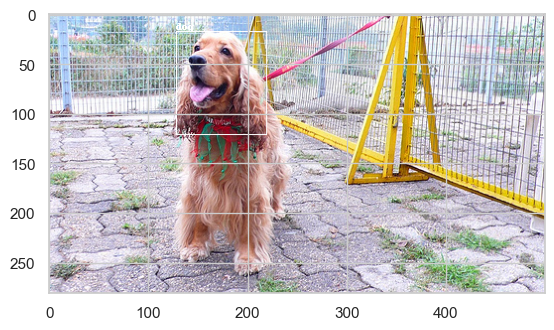

In [282]:

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
coco_folder_path = "annotations/coco/"
coco_file_paths = [os.path.join(coco_folder_path, file) for file in os.listdir(coco_folder_path) if os.path.isfile(os.path.join(coco_folder_path, file))]

annotation_file = random.choice(coco_file_paths)
print(annotation_file)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("/coco","").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [321]:
import os
import shutil

def copiar_archivos_si_existen(origen, destino, tercera_carpeta, extension=".xml"):
    try:
        # Comprueba si la carpeta de destino existe, y si no, la crea
        if not os.path.exists(destino):
            os.makedirs(destino)

        # Lista los archivos en la tercera carpeta con la extensión especificada
        archivos = [f for f in os.listdir(tercera_carpeta) if f.endswith(extension)]
        # Copia cada archivo a la carpeta de destino
        for archivo in archivos:
            ruta_origen = os.path.join(origen, archivo.replace("xml","jpg"))
            ruta_destino = os.path.join(destino, archivo.replace("xml","jpg"))
            shutil.copy(ruta_origen, ruta_destino)
            print(f"Archivo '{archivo}' copiado de '{origen}/{tercera_carpeta}' a '{destino}'")

        print("Operación completada.")
    except Exception as e:
        print(f"Error: {e}")

# Especifica la carpeta de origen, la carpeta de destino y la tercera carpeta
carpeta_origen = "images"
carpeta_destino = "obj_detection/head_annotated_imgs"
tercera_carpeta = os.path.join("annotations", "xmls")

# Llama a la función para copiar archivos si existen en la tercera carpeta
copiar_archivos_si_existen(carpeta_origen, carpeta_destino, tercera_carpeta)


Archivo 'Abyssinian_1.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_10.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_100.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_101.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_102.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_103.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_105.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_106.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_107.xml' copiado de 'images/annotations\xmls' a 'obj_detection/head_annotated_imgs'
Archivo 'Abyssinian_108.xml' copiado de 'images/annotations\xmls' a

In [325]:
# Read images and annotations
images = [os.path.join('obj_detection/head_annotated_imgs', x) for x in os.listdir('obj_detection/head_annotated_imgs')]
annotations = [os.path.join('annotations/coco', x) for x in os.listdir('annotations/coco') if x[-3:] == "txt"]

images.sort()
print(len(images))
annotations.sort()
print(len(annotations))

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

3686
3686


In [333]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
print(train_annotations)
# move_files_to_folder(train_images, 'obj_detection/images/train')
# move_files_to_folder(val_images, 'obj_detection/images/val/')
# move_files_to_folder(test_images, 'obj_detection/images/test/')
move_files_to_folder(train_annotations, 'obj_detection/annotations/train/')
move_files_to_folder(val_annotations, 'obj_detection/annotations/val/')
move_files_to_folder(test_annotations, 'obj_detection/annotations/test/')

['annotations/coco\\beagle_168.txt', 'annotations/coco\\Siamese_199.txt', 'annotations/coco\\boxer_164.txt', 'annotations/coco\\Maine_Coon_109.txt', 'annotations/coco\\american_bulldog_125.txt', 'annotations/coco\\British_Shorthair_148.txt', 'annotations/coco\\miniature_pinscher_138.txt', 'annotations/coco\\japanese_chin_155.txt', 'annotations/coco\\Abyssinian_182.txt', 'annotations/coco\\great_pyrenees_138.txt', 'annotations/coco\\chihuahua_107.txt', 'annotations/coco\\samoyed_158.txt', 'annotations/coco\\german_shorthaired_12.txt', 'annotations/coco\\pug_184.txt', 'annotations/coco\\Bombay_193.txt', 'annotations/coco\\great_pyrenees_169.txt', 'annotations/coco\\staffordshire_bull_terrier_195.txt', 'annotations/coco\\beagle_10.txt', 'annotations/coco\\Maine_Coon_193.txt', 'annotations/coco\\Ragdoll_16.txt', 'annotations/coco\\wheaten_terrier_181.txt', 'annotations/coco\\Abyssinian_109.txt', 'annotations/coco\\Russian_Blue_166.txt', 'annotations/coco\\american_bulldog_171.txt', 'annota

In [347]:
!python yolov5\\train.py --img 640 --cfg yolov5x.yaml  --batch 32 --epochs 2 --data yolov5\\cat_dogs_data.yaml --weights yolov5\\yolov5x.pt --workers 24 --name cats_dogs

train: weights=yolov5\\yolov5s.pt, cfg=yolov5x.yaml, data=yolov5\\cat_dogs_data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=2, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5\data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5\runs\train, name=cats_dogs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-267-gc42aba5 Python-3.11.5 torch-2.1.2 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup

In [350]:
!python yolov5\\detect.py --source ../obj_detection/images/test/ --weights yolov5\\runs/train/cats_dogs/weights/best.pt --conf 0.25 --name cats_dogs

detect: weights=['yolov5\\\\runs/train/cats_dogs/weights/best.pt'], source=../obj_detection/images/test/, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=cats_dogs, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-267-gc42aba5 Python-3.11.5 torch-2.1.2 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6144MiB)

Traceback (most recent call last):
  File "d:\Escritorio\AprenentatgeAutomatic\p2\yolov5\detect.py", line 295, in <module>
    main(opt)
  File "d:\Escritorio\AprenentatgeAutomatic\p2\yolov5\detect.py", line 290, in main
    run(**vars(opt))
  File "d:\miniconda\Lib\site-packages\torch\utils\_contextlib.py", line 115, in decorate_context
    return func(*args, *

In [361]:
!python yolov5\\test.py --weights runs/train/cats_dogs/weights/best.pt --data yolov5\\cat_dogs_data.yaml --task test --name yolo_det

python: can't open file 'd:\\Escritorio\\AprenentatgeAutomatic\\p2\\yolov5\\test.py': [Errno 2] No such file or directory
